In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# polygons = np.array([
#     #[(100,height),(width,height),(width,267),(320,170)]
#     #[(30,height),(450,height),(280,130)]
#     [(0,240),(0,100), (100,100),(280,100), (320,100), (320,240)] ##lane13
# ])
image = cv2.imread('../Image/lane_13.png')
HEIGHT = image.shape[0]
WEIGHT = image.shape[1]
print(image.shape)
imshape = image.shape
# polygons = np.array([[(int(0.21*imshape[1]),imshape[0]),(int(0.44*imshape[1]), 
#             int(0.59*imshape[0])), (int(0.50*imshape[1]), int(0.59*imshape[0])), (
#             imshape[1],imshape[0])]], dtype=np.int32)

polygons = np.array([[(int(0*imshape[1]),imshape[0]),(int(0.15*imshape[1]), 
            int(0.4*imshape[0])), (int(0.80*imshape[1]), int(0.4*imshape[0])), (
            imshape[1],imshape[0])]], dtype=np.int32)

# cv2.imshow('Image',image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.figure()
plt.imshow(image)

mask = np.zeros_like(image)
cv2.fillPoly(mask,polygons,255)
#         plt.figure()
#         plt.imshow(mask,cmap='gray')
masked_image = cv2.bitwise_and(image,mask)
plt.figure()
plt.imshow(masked_image)


(240, 320, 3)


In [3]:
#Denoise image

In [4]:
#binary image

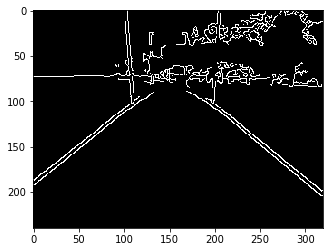

In [5]:
#edge detected
def canny(image):
        image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(image_gray,(5,5),0)
        canny = cv2.Canny(blur,50,250)
        return canny
canny_image = canny(image)
plt.imshow(canny_image,cmap='gray')

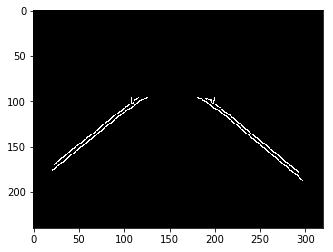

In [6]:
#masked
def region_of_interest(image):
#         height = image.shape[0]
#         width = image.shape[1]
#         x = [210, 550,717 ,1280];
#         y = [720, 450, 450, 720];
        mask = np.zeros_like(image)
        cv2.fillPoly(mask,polygons,255)
#         plt.figure()
#         plt.imshow(mask,cmap='gray')
        masked_image = cv2.bitwise_and(image,mask)
        return masked_image

crop_image = region_of_interest(canny_image)
plt.figure()
plt.imshow(crop_image, cmap= 'gray')

In [7]:
def find_slopes_lines(image):
    canny_image = canny(image)
    
    crop_image = region_of_interest(canny_image)
    lines = cv2.HoughLinesP(crop_image,2,np.pi/180,50,np.array([]),minLineLength=20,maxLineGap=100)
    ## y=mx+b
    line_image=np.zeros_like(image)
    #print(lines.shape)
    x = lines[:,:,0:2]
    x = x.reshape(len(lines),2)
    y = lines[:,:,2:4]
    y = y.reshape(len(lines),2)
    
    #Test
#     print(x.shape,'x shape')
#     plt.scatter(x[:,0],x[:,1])
#     plt.scatter(y[:,0],y[:,1])
#     plt.imshow(image)
    
    
    slopes = []
    lines_update = []
    threshold = 0.35
    for l in range(len(lines)):
        if (y[l][0]-x[l][0] < 0.1):
            slope = 1000 # //oy
        else:
            slope = (y[l][1]-x[l][1])/(y[l][0]-x[l][0])

        if (abs(slope) > threshold):
            slopes.append(slope)
            lines_update.append(lines[l])
    return slopes,lines_update
slopes, lines_update = find_slopes_lines(image)
print(slopes)
print(lines_update)



[0.8148148148148148, -0.8089887640449438, -0.8020833333333334, 0.8125, 0.7623762376237624, 0.7821782178217822, -0.8404255319148937, -0.7011494252873564]
[array([[189,  99, 297, 187]], dtype=int32), array([[ 23, 170, 112,  98]], dtype=int32), array([[ 21, 176, 117,  99]], dtype=int32), array([[195,  98, 291, 176]], dtype=int32), array([[191, 100, 292, 177]], dtype=int32), array([[184,  97, 285, 176]], dtype=int32), array([[ 22, 175, 116,  96]], dtype=int32), array([[ 36, 158, 123,  97]], dtype=int32)]


(8, 1, 4) update lines
(8, 2)
(8, 2)
[[189  99]
 [ 23 170]
 [ 21 176]
 [195  98]
 [191 100]
 [184  97]
 [ 22 175]
 [ 36 158]] xx
[[297 187]
 [112  98]
 [117  99]
 [291 176]
 [292 177]
 [285 176]
 [116  96]
 [123  97]] yy


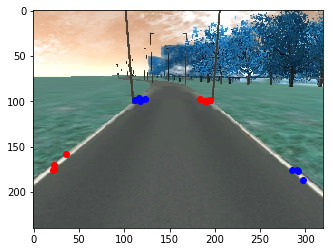

In [8]:
def split_hough_point(lines_update):
    lines_update = np.array(lines_update)
    print(lines_update.shape,'update lines')
    xx = lines_update[:,:,0:2]
    xx = xx.reshape(len(lines_update),2)
    yy = lines_update[:,:,2:4]
    yy = yy.reshape(len(lines_update),2)
    return xx,yy
xx,yy = split_hough_point(lines_update)
print(yy.shape)
print(xx.shape)
print(xx,'xx')
print(yy,'yy')
plt.scatter(xx[:,0],xx[:,1],color='red')
plt.scatter(yy[:,0],yy[:,1],color='blue')
plt.imshow(image)

8 lines_update
(8, 1, 4) update lines
(4, 1, 4) right-line_shape
(4, 1, 4) left-line_shape
(4, 1, 4) update lines
(4, 1, 4) update lines


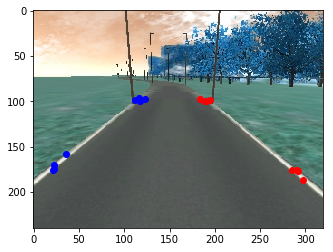

In [9]:
def detect_left_right(image):


    slopes,lines_update = find_slopes_lines(image)
    #print(slopes)
    print(len(lines_update),'lines_update')
    first,second = split_hough_point(lines_update)
    center = image.shape[1]/2
    right_lines = []
    left_lines = []
    tag = []
    #global tagleft,tagright
    for l in range(len(lines_update)):
        #print(l,': Index')
        if ((slopes[l] > 0) and (first[l][0] > center) and (second[l][0] > center)) :
            right_lines.append(lines_update[l])
            tagright = 1;
            tagleft = 0;
#             plt.scatter(first[l][0],first[l][1],color='red')
#             plt.scatter(second[l][0],second[l][1],color='yellow')
        elif((slopes[l] < 0)  and (first[l][0] < center) and (second[l][0] < center-20)) :
            left_lines.append(lines_update[l])
            tagleft = 1;
            tagright = 0;
#             plt.scatter(first[l][0],first[l][1],color='blue')
#             plt.scatter(second[l][0],second[l][1],color='blue')
        plt.imshow(image)
    right_lines = np.array(right_lines)
#     right_lines = right_lines.reshape(right_lines.shape[0],4)
    left_lines  = np.array(left_lines)
#     left_lines  = left_lines.reshape(left_lines.shape[0],4)
    return right_lines,left_lines
right_lines, left_lines = detect_left_right(image)
print(right_lines.shape,'right-line_shape')
print(left_lines.shape,'left-line_shape')
##first and second point
st1,rd1 = split_hough_point(right_lines)
plt.scatter(st1[:,0],st1[:,1],color='red')
plt.scatter(rd1[:,0],rd1[:,1],color='red')

st2,rd2 = split_hough_point(left_lines)
plt.scatter(st2[:,0],st2[:,1],color='blue')
plt.scatter(rd2[:,0],rd2[:,1],color='blue')
plt.imshow(image)

8 lines_update
(8, 1, 4) update lines
(4, 1, 4) update lines
(4, 1, 4) update lines
[[ 23 170]
 [ 21 176]
 [ 22 175]
 [ 36 158]] first
[[112  98]
 [117  99]
 [116  96]
 [123  97]] second
[[ 23  21  22  36]
 [112 117 116 123]] x_ shape
(2, 4) y_ shape
368.4427892524219 right_x1
240 right_x1
216.8068908791811 right_x2
120.0 right_x2


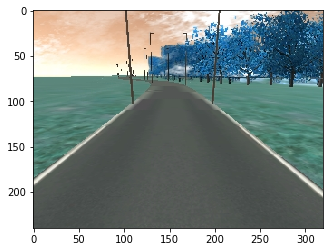

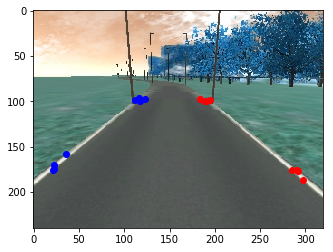

In [10]:
def detect(image):
    right_lines, left_lines = detect_left_right(image)
    first_r,second_r = split_hough_point(right_lines)
    first_l,second_l = split_hough_point(left_lines)
    x_r = np.array((first_r[:,0],second_r[:,0]))
    x_r = x_r.reshape(x_r.shape[0]*x_r.shape[1])
    y_r = np.array((first_r[:,1],second_r[:,1]))
    y_r = y_r.reshape(y_r.shape[0]*y_r.shape[1])
    
    
    print(first_l,'first')
    print(second_l,'second')
    
    x_l = np.array((first_l[:,0],second_l[:,0]))
    y_l = np.array((first_l[:,1],second_l[:,1]))
    print(x_l,'x_ shape')
    print(y_l.shape,'y_ shape')
    x_l = x_l.reshape(x_l.shape[0]*x_l.shape[1])
    y_l = y_l.reshape(y_l.shape[0]*y_l.shape[1])
    plt.figure()
    plt.scatter(x_r,y_r,color='red')
    plt.scatter(x_l,y_l,color='blue')
    plt.imshow(image)
    if (len(x_r)>0):
        pol = np.polyfit(x_r,y_r,1)
        rm  = pol[0]
        rb  = pol[1]
    else:
        rm = 1
        rb =1
        
    if (len(x_l)>0):
        pol = np.polyfit(x_l,y_l,1)
        lm  = pol[0]
        lb  = pol[1]
    else:
        lm = 1
        lb =1
    line_image=np.zeros_like(image)
    y1 = image.shape[0]
    y2 = y1/2
    right_x1 = (y1 - rb) / rm;
    right_x2 = (y2 - rb) / rm;
    left_x1 = (y1 - lb) / lm;
    left_x2 = (y2 - lb) / lm;
    
    polygons = np.array([
        #[(100,height),(width,height),(width,267),(320,170)]
        #[(30,height),(450,height),(280,130)]
      #   [(250, 700), (550,450), (717,450),(1280,720)]
      [(int(left_x1), int(y1)), (int(left_x2), int(y2)),(int(right_x2), int(y2)),(int(right_x1), int(y1))]
    ])
    return left_x1,left_x2, right_x1,right_x2
        
left_x1,left_x2, right_x1,right_x2  = detect(image)
y1 = image.shape[0]
y2 = y1/2
print(right_x1,'right_x1')
print(y1, 'right_x1')
print(right_x2,'right_x2')
print(y2, 'right_x2')
    

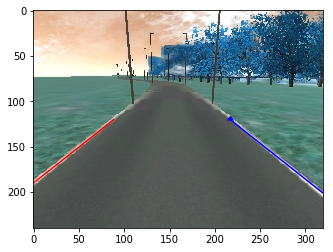

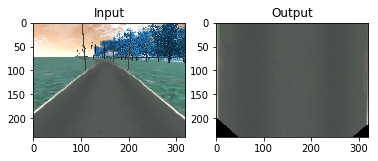

In [11]:
pts1 = np.float32([[left_x2, y2],[right_x2, y2],[left_x1, y1],[right_x1, y1]])
pts2 = np.float32([[0,0],[WEIGHT,0],[0,HEIGHT],[WEIGHT,HEIGHT]])
plt.figure()
plt.plot((left_x1,left_x2),(y1,y2),color='red')
plt.plot((right_x1,right_x2),(y1,y2),color='blue',marker=10)
plt.imshow(image)
M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(image,M,(WEIGHT,HEIGHT))

plt.figure()
plt.subplot(121),plt.imshow(image),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [12]:
# plt.figure()
# mask = np.zeros_like(image)
# cv2.fillPoly(mask,polygons,255)
# masked_image = cv2.bitwise_or(mask,image)
# plt.imshow(masked_image, cmap='gray')
# anpha = 10 + np.arctan(rm)
# print(anpha,'alpha')
# deg_right = (np.arctan(rm)*180/np.pi)
# deg_left = (-np.arctan(lm)*180/np.pi)
# print(deg_right,'rm')
# print(deg_left,'lm')

# x1_center = (left_x1+right_x1)/2
# x2_center = (left_x2+right_x2)/2
# plt.scatter(x1_center,y1,color='red')
# plt.scatter(x2_center,y2,color='yellow')
# pol = np.polyfit((x1_center,x2_center),(y1,y2),1)
# ang_center = pol[0]
# ang_center = np.arctan(ang_center)*180/np.pi
# print(ang_center,"angle")
# #     if (deg_right<= 37 or deg_left >=40):
# #         steer =  42-deg_right
# #         #cv2.putText(masked_image, 'LEFT {} deg'.format(steer), (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
# #         #cv2.putText(masked_image, 'RIGHT {0:.2f}(L: {0:.2f}-R:{0:.2f})'.format(self.steer, round(deg_left,2),round(deg_right,2)), (00, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_4)
# #         print('turn left')
# #         plt.text(0,200,'TURN LEFT {} deg (left: {} deg -- right:{})'.format(round(steer,2),round(deg_left,2),round(deg_right,2)))

# #     elif (deg_left <35 or deg_right >= 40):
# #         steer = 40 - deg_left 
# #         #cv2.putText(masked_image, 'RIGHT {} deg'.format(steer), (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
# #         #cv2.putText(masked_image, 'LEFT {0:.2f} (L:{0:.2f}-R:{0:.2f})'.format(self.steer, round(deg_left,2),round(deg_right,2)), (0, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2,cv2.LINE_4)
# #         print('turn right') 
# #         plt.text(0,200,'TURN LEFT {} deg (left: {} deg -- right:{})'.format(round(steer,2),round(deg_left,2),round(deg_right,2)))
# #     else:
# #         cv2.putText(masked_image, 'STRAIGH', (140, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
# #         print('go straight')
#     #cv2.imshow('image',masked_image)
#     #cv2.waitKey(0)
    
    
#     if (ang_center < 0 and ang_center > -85):
#         steer = 90 + ang_center    # turn right
#     elif (ang_center > 0 and ang_center < 85):
#         steer = 90 - ang_center    #tuurn left 
#     else:
#         steer = 0
#     print(steer,'steer')
# detect(image)

In [13]:

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # Function has been written to work with Challenge video as well
    # b -0, g-1, r-2 
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # At the bottom of the image, imshape[0] and top has been defined as 330
    imshape = img.shape 
    
    slope_left=0
    slope_right=0
    leftx=0
    lefty=0
    rightx=0
    righty=0
    i=0
    j=0
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope >0.1: #Left lane and not a straight line
                # Add all values of slope and average position of a line
                slope_left += slope 
                leftx += (x1+x2)/2
                lefty += (y1+y2)/2
                i+= 1
            elif slope < -0.2: # Right lane and not a straight line
                # Add all values of slope and average position of a line
                slope_right += slope
                rightx += (x1+x2)/2
                righty += (y1+y2)/2
                j+= 1
    # Left lane - Average across all slope and intercepts
    if i>0: # If left lane is detected
        avg_slope_left = slope_left/i
        avg_leftx = leftx/i
        avg_lefty = lefty/i
        # Calculate bottom x and top x assuming fixed positions for corresponding y
        xb_l = int(((int(0.97*imshape[0])-avg_lefty)/avg_slope_left) + avg_leftx)
        xt_l = int(((int(0.61*imshape[0])-avg_lefty)/avg_slope_left)+ avg_leftx)

    else: # If Left lane is not detected - best guess positions of bottom x and top x
        xb_l = int(0.21*imshape[1])
        xt_l = int(0.43*imshape[1])
    
    # Draw a line
    cv2.line(img, (xt_l, int(0.61*imshape[0])), (xb_l, int(0.97*imshape[0])), color, thickness)
    
    #Right lane - Average across all slope and intercepts
    if j>0: # If right lane is detected
        avg_slope_right = slope_right/j
        avg_rightx = rightx/j
        avg_righty = righty/j
        # Calculate bottom x and top x assuming fixed positions for corresponding y
        xb_r = int(((int(0.97*imshape[0])-avg_righty)/avg_slope_right) + avg_rightx)
        xt_r = int(((int(0.61*imshape[0])-avg_righty)/avg_slope_right)+ avg_rightx)
    
    else: # If right lane is not detected - best guess positions of bottom x and top x
        xb_r = int(0.89*imshape[1])
        xt_r = int(0.53*imshape[1])
    
    # Draw a line    
    cv2.line(img, (xt_r, int(0.61*imshape[0])), (xb_r, int(0.97*imshape[0])), color, thickness)

def weighted_img(img, initial_img, alpha=0.8, beta=1., lamda=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, lamda)